In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, \
                                        BatchNormalization, Embedding, Masking,\
                                        Bidirectional, Conv1D, MaxPooling1D, Flatten, concatenate, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier

import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import shap

In [2]:
def generate_time(start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])
    
def query_status(eq_id):
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'TFM4CEBERUS',
                password = 'TFM4CEBERUS',
                hostname = 'ome-db.bth.infineon.com',
                port = '1538',
                database = 'ome'
                )
            )
    except Exception as e:
        print(str(e))

    query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
            from (SELECT
              eq.eq_id, eq.name, eq.eq_type_ident
            , data.timestamp_start,data.timestamp_end
            , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
            , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
            , level5s.state_name
            , level5.state_name Level5_Name, level5.state_sign Level5
            , level4.state_name Level4_Name, level4.state_sign Level4
            , level3.state_name Level3_Name, level3.state_sign Level3
            ,mh.device
            ,mh.package,
            mh.lotid as lot,
            mh.product,
            mh.operation

            FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
            , OMEADMIN.EQUIPMENT_INSTANCES eq
            , V_EQ_STATES level5s
            , OMEADMIN.DEF_STANDARD_STATEMODEL level5
            , OMEADMIN.DEF_STANDARD_STATEMODEL level4
            , OMEADMIN.DEF_STANDARD_STATEMODEL level3
            , OMEDATA.METAKEY_HISTORY mh

            WHERE data.eq_ident  = eq.eq_ident
            AND  data.eq_status = level5s.state_ident(+)
            AND level5.state_ident = data.tr25_5_status
            AND level4.state_ident = data.tr25_4_status
            AND level3.state_ident = data.tr25_3_status
            AND  data.metakey_ident =mh.ident(+)
            and data.timestamp_start > sysdate - 1050)
            where eq_id = '{eq_id}'
            ORDER BY TIMESTAMP_START"""

    status = pd.read_sql(query, engine)
    status.columns = map(lambda x: str(x).upper(), status.columns) 

    return status

def aggregate(timeframe_table, lookback_window, status_table):
    statename_df = pd.DataFrame(columns=status_table["STATE_NAME"].unique())

    for idx, row in timeframe_table.iterrows():
        end = row["TIMESTAMP"]
        start = end - timedelta(hours=lookback_window)

        ## count the frequencies of each statename, include everything since feature engineering would be performed
        filtered_statename = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & 
                                              (status_table["TIMESTAMP_START"] <= end)]
        unique = filtered_statename["STATE_NAME"].unique()
        status_dict = {key:int(sum(filtered_statename.loc[filtered_statename.STATE_NAME==key]["DURATION"])) 
                       for key in unique}
        
        statename_df = statename_df.append(status_dict, ignore_index=True)
            
    statename_df = statename_df.fillna(0)
    cols = statename_df.columns
    statename_df[cols] = statename_df[cols].astype('int')
    return statename_df


def status_sequence(input_table, status_table, hour, scaled=False):
        status_seq = []
        duration_seq = []
        
        # validation check
        if status_table.iloc[0]["TIMESTAMP_START"] > input_table.iloc[0]["TIMESTAMP"]:
            raise Exception("Timeframe table must be a subset of the status table")
        if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_table.iloc[len(input_table)-1]["TIMESTAMP"]:
                raise Exception("Timeframe table must be a subset of the status table")
        
        for idx, row in input_table.iterrows():
            end = row["TIMESTAMP"]
            start = end - timedelta(hours=hour)
            
            condition = (status_table["TIMESTAMP_START"]>=start) & (status_table["TIMESTAMP_START"]<=end)

            table = status_table[condition]
            status_seq.append(table["STATE_NAME"].values)
            if scaled:
                duration_seq.append(table["SCALED_DURATION"].values)
            else:
                duration_seq.append(table["DURATION"].values)

        return status_seq, duration_seq


def major_down(input_df, status_table, hour, threshold): 
        hour = pd.Timedelta(hours=hour)
        major_down = []

        for idx, row in input_df.iterrows():
            start = row['TIMESTAMP']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']
            
            # disregard "waiting" in statename

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>=threshold): #threshold = 3600s
                    major_down.append(1)
                else:
                    major_down.append(0)
        return np.array(major_down)

def query_CAMSTAR(eq_id):
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'bth_odsprod',
                password = 'bth_odsprodbth',
                hostname = 'odsprod-db.bth.infineon.com',
                port = '1523',
                database = 'odsprod'
                )
            )
    except Exception as e:
        print(str(e))

    query = f"""select EQUIPMENTNAME AS EQ_ID, TRACKINTIMESTAMP, TRACKOUTTIMESTAMP from A_WIPEQUIPMENTHISTORY t
                where t.equipmentname = '{eq_id}'
                ORDER BY TRACKINTIMESTAMP"""

    status = pd.read_sql(query, engine)

    return status

def label_encode(statename_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_statename = [set(ele) for ele in statename_seq]
    unique_statenames = set()
    for ele in all_unique_statename:
        unique_statenames |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_statenames:
        mapping_dict[ele] = enc_label
        enc_label += 1

    enc_array = []
    #X_seq is a 3D array
    for timestamp in statename_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_statenames)+1, mapping_dict

In [3]:
# data loading
wba127_status_table = query_status("WBA127")

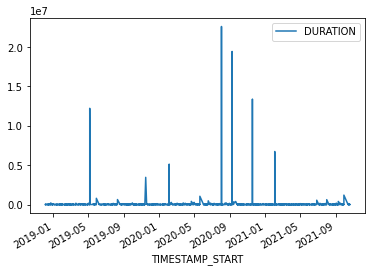

In [4]:
status = wba127_status_table.copy()

status = status[:-1]
duration_time = status.loc[:,["TIMESTAMP_START", "DURATION"]].set_index("TIMESTAMP_START")
duration_time.plot(subplots=True)
plt.show() # from here we know that the duration variable has a wide range of values, find out the max

In [5]:
status.loc[status.DURATION==max(status.DURATION)] 
# this machine was on standby for half a year
# drop this row of data

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
73696,WBA127,2020-08-03 17:52:06,2021-04-22 08:15:37,22602211.0,PlanIdle,Standby (SB),SBY


In [6]:
# find out the top 5 longest duration and their status
duration_sort = status.sort_values('DURATION', ascending=False).head(20)
duration_sort
# notice for some rows (74746), even though machine is already on standby, there are still transaction in the middle

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
73696,WBA127,2020-08-03 17:52:06,2021-04-22 08:15:37,22602211.0,PlanIdle,Standby (SB),SBY
77407,WBA127,2020-09-09 10:19:49,2021-04-22 08:15:37,19432548.0,IT Maintenance,Scheduled Down (SD),SDT
85179,WBA127,2020-11-18 10:19:38,2021-04-22 08:15:37,13384559.0,IT Maintenance,Scheduled Down (SD),SDT
19905,WBA127,2019-05-07 08:33:07,2019-09-25 17:31:57,12214730.0,Half Yearly PM,Scheduled Down (SD),SDT
97375,WBA127,2021-02-03 10:13:15,2021-04-22 08:15:37,6732142.0,IT Maintenance,Scheduled Down (SD),SDT
55557,WBA127,2020-02-05 09:50:15,2020-04-04 18:07:43,5127448.0,IT Maintenance,Scheduled Down (SD),SDT
44484,WBA127,2019-11-16 09:35:21,2019-12-26 08:05:11,3450590.0,Engineering PRE,Engineering (EN),ENG
137052,WBA127,2021-09-29 21:49:27,2021-10-13 17:16:28,1193221.0,PlanIdle,Standby (SB),SBY
67641,WBA127,2020-05-21 05:09:46,2020-06-02 08:10:02,1047616.0,Non Schedule Time,Non-scheduled time (NS),NST
23250,WBA127,2019-05-30 05:14:25,2019-06-08 08:57:31,790986.0,Non Schedule Time,Non-scheduled time (NS),NST


In [7]:
# check these rows, how many transactions are in the middle
for idx in duration_sort.index:
    start = status.iloc[idx]["TIMESTAMP_START"]
    end = status.iloc[idx]["TIMESTAMP_END"]
    filtered = status.loc[(status.TIMESTAMP_START>=start) & (status.TIMESTAMP_START<end)]
    print(f'In between timestamp of row {idx}, there are {len(filtered)-1} transactions')
    
# for status with other transaction in the middle, should they be invalid

In between timestamp of row 73696, there are 36668 transactions
In between timestamp of row 77407, there are 32957 transactions
In between timestamp of row 85179, there are 25185 transactions
In between timestamp of row 19905, there are 17961 transactions
In between timestamp of row 97375, there are 12989 transactions
In between timestamp of row 55557, there are 7040 transactions
In between timestamp of row 44484, there are 5404 transactions
In between timestamp of row 137052, there are 0 transactions
In between timestamp of row 67641, there are 0 transactions
In between timestamp of row 23250, there are 0 transactions
In between timestamp of row 33367, there are 0 transactions
In between timestamp of row 128116, there are 0 transactions
In between timestamp of row 122248, there are 0 transactions
In between timestamp of row 70156, there are 0 transactions
In between timestamp of row 64615, there are 0 transactions
In between timestamp of row 134699, there are 0 transactions
In between

In [8]:
# there are rows with 0 as DURATION
duration_sort_asc = status.sort_values('DURATION', ascending=True).head()
zero_seconds = status.loc[status.DURATION==0.0]
print(f'There are {len(zero_seconds)} rows with 0.0 seconds as DURATION')
print(f'Distribution of LEVEL3:\n{zero_seconds["LEVEL3"].value_counts()}')
duration_sort_asc

There are 850 rows with 0.0 seconds as DURATION
Distribution of LEVEL3:
PRD    376
SDT    182
UDT    157
SBY    126
EXC      8
NST      1
Name: LEVEL3, dtype: int64


,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
2574,WBA127,2018-12-27 09:29:58,2018-12-27 09:29:58,0.0,Waiting For Response,Standby (SB),SBY
131840,WBA127,2021-08-26 10:19:44,2021-08-26 10:19:44,0.0,Waiting For Response,Standby (SB),SBY
35600,WBA127,2019-09-08 23:12:15,2019-09-08 23:12:15,0.0,Waiting For Response,Standby (SB),SBY
64459,WBA127,2020-04-19 04:44:42,2020-04-19 04:44:42,0.0,Normal Production,Productive (PR),PRD
35654,WBA127,2019-09-09 12:19:17,2019-09-09 12:19:17,0.0,Waiting For Response,Standby (SB),SBY


In [9]:
# apparently status can be uncontinuous, there might be some transaction in between timestamp of each row
# find rows which the timestamp end is later than the next timestamp start
# to prove all those with status in the middle are recorded wrongly

# also find out rows with the same state name and is split into 2

idx_row = []
same_state_idx = []
for idx, row in status.iterrows():
    if idx == len(status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]

    if end > next_start:
        idx_row.append(idx)
    if end == next_start and state1 == state2:
        same_state_idx.append(idx)
    
print(f'Rows with overlapping transaction {idx_row}')
print(f'There are {len(same_state_idx)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction [607, 632, 2259, 3512, 4766, 4782, 4784, 6601, 7203, 7619, 8990, 9150, 9341, 9345, 10619, 11907, 12288, 12500, 12604, 13481, 14228, 14286, 14722, 14771, 16123, 16693, 19905, 19906, 22428, 22826, 23240, 23289, 23885, 24403, 24446, 24888, 25324, 25738, 26643, 26986, 28358, 29291, 30521, 30602, 30702, 31442, 32059, 33146, 33165, 33827, 35048, 35246, 35653, 36265, 37062, 37842, 37931, 37970, 38056, 38432, 38546, 39345, 39358, 39879, 40510, 40701, 40804, 41280, 42240, 42453, 42768, 42857, 42980, 43381, 44484, 44634, 44822, 45444, 46175, 48050, 48105, 48719, 48725, 48729, 49302, 49384, 50087, 50395, 51348, 51828, 52898, 53009, 55557, 55743, 56089, 56972, 58264, 58270, 58644, 58765, 59055, 59329, 59371, 59410, 60174, 60612, 60736, 60955, 61164, 61295, 61865, 63000, 63008, 63656, 63915, 63984, 64066, 64071, 64454, 66198, 66486, 70301, 71805, 72937, 73696, 73782, 74097, 75364, 76174, 77407, 78126, 79550, 80735, 81796, 82891, 82993, 84944, 85043, 85179, 85180, 8

In [10]:
# some of the rows have the same state name but is split into 2 transaction

idx = same_state_idx[-1]
status.iloc[idx:idx+2]

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
137767,WBA127,2021-10-20 04:11:47,2021-10-20 05:19:23,4056.0,Normal Production,Productive (PR),PRD
137768,WBA127,2021-10-20 05:19:23,2021-10-20 05:29:52,629.0,Normal Production,Productive (PR),PRD


In [11]:
special = ["ENG", "NST", "EXC"]
special_table = status.loc[status.LEVEL3.isin(special)]
print(f'There are {len(special_table)} rows of transactions with special LEVEL3')

There are 140 rows of transactions with special LEVEL3


In [12]:
# clean up status data 
# (do not remove special level3 as sometimes engineers would run dummy lot and CAMSTAR will not have record but TFM has)

# 1. combine timestamp_end == next row timestamp_start, start from the back as there are some with continuous rows
clean_status = status.copy()
for idx in reversed(same_state_idx):
    duration = sum(clean_status.iloc[idx:idx+2]["DURATION"])
    clean_status.at[idx, 'DURATION'] = duration
    clean_status.at[idx, 'TIMESTAMP_END'] = clean_status.iloc[idx+1]["TIMESTAMP_END"]
    clean_status.drop(index=idx+1, axis=0, inplace=True)
    
clean_status = clean_status.reset_index(drop=True)

In [13]:
# validate all timestamp_end == timestamp start with same state name datapoints have been combined
idx_rows = []
same_state = []
for idx, row in clean_status.iterrows():
    if idx == len(clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    if end > next_start:
        idx_rows.append(idx)
    if end == next_start and state1 == state2:
        same_state.append(idx)
    
print(f'Rows with overlapping transaction {idx_rows}')
print(f'There are {len(same_state)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction [586, 611, 2205, 3430, 4645, 4660, 4662, 6442, 7031, 7440, 8771, 8926, 9112, 9115, 10352, 11616, 11991, 12198, 12300, 13150, 13865, 13922, 14349, 14396, 15719, 16274, 19431, 19432, 21913, 22303, 22706, 22751, 23333, 23850, 23892, 24330, 24761, 25166, 26052, 26382, 27721, 28643, 29848, 29926, 30023, 30742, 31347, 32407, 32425, 33068, 34268, 34461, 34862, 35465, 36256, 37010, 37095, 37134, 37215, 37576, 37687, 38465, 38478, 38994, 39615, 39798, 39898, 40369, 41300, 41504, 41808, 41892, 42012, 42410, 43492, 43640, 43825, 44432, 45140, 46982, 47036, 47637, 47642, 47645, 48208, 48285, 48965, 49266, 50204, 50680, 51725, 51831, 54301, 54482, 54819, 55683, 56950, 56955, 57322, 57442, 57726, 57999, 58040, 58078, 58827, 59253, 59372, 59586, 59790, 59916, 60472, 61578, 61585, 62220, 62475, 62541, 62621, 62625, 63003, 64720, 65003, 68776, 70243, 71348, 72088, 72170, 72478, 73711, 74502, 75710, 76405, 77778, 78938, 79987, 81061, 81162, 83068, 83166, 83300, 83301, 8

In [14]:
# 2. Remove the rows with overlapping timestamp_end = timestamp_start
len3 = len(clean_status)
clean_status = clean_status.drop(index=idx_rows, axis=0).reset_index(drop=True)
len4 = len(clean_status)
print(f'Removed {len3-len4} rows of data with long duration (overlapping timestamp start and end)')

# 3. Remove duration = 0
len1 = len(clean_status)
clean_status = clean_status[~(clean_status.DURATION==0.0)].reset_index(drop=True)
len2 = len(clean_status)
print(f'Removed {len1-len2} rows of data with duration as 0.0')

Removed 232 rows of data with long duration (overlapping timestamp start and end)
Removed 844 rows of data with duration as 0.0


In [15]:
# 4. Check again and make sure no overlapping timestamp (all timestamp_start must be >= last timestamp_end)
idx_rows_check = []
same_state_check = []
for idx, row in clean_status.iterrows():
    
    if idx == len(clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    if end > next_start:
        idx_rows_check.append(idx)
    if end == next_start and state1 == state2:
        same_state_check.append(idx)
    
print(f'Rows with overlapping transaction {idx_rows_check}')
print(f'There are {len(same_state_check)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction []
There are 501 rows with the same state name as the next row with the same timestamp


In [16]:
# more rows with timestamp_end == timestamp_start has surfaced because we removed the 0.0 duration
# combine these rows again

for idx in reversed(same_state_check):
    duration = sum(clean_status.iloc[idx:idx+2]["DURATION"])
    clean_status.at[idx, 'DURATION'] = duration
    clean_status.at[idx, 'TIMESTAMP_END'] = clean_status.iloc[idx+1]["TIMESTAMP_END"]
    clean_status.drop(index=idx+1, axis=0, inplace=True)
    
clean_status = clean_status.reset_index(drop=True)


#check again to confirm no more timestamp_end == timestmap_start
idx_rows_check_2 = []
same_state_check_2 = []
for idx, row in clean_status.iterrows():
    
    if idx == len(clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    if end > next_start:
        idx_rows_check_2.append(idx)
    if end == next_start and state1 == state2:
        same_state_check_2.append(idx)

In [17]:
print(f'Rows with overlapping transaction {idx_rows_check_2}')
print(f'There are {len(same_state_check_2)} rows with the same state name as the next row with the same timestamp')
print(f'Removed a total of {len(status)-len(clean_status)} rows from {len(status)}.')

Rows with overlapping transaction []
There are 0 rows with the same state name as the next row with the same timestamp
Removed a total of 4363 rows from 137770.


In [18]:
wba127_clean_status = clean_status.copy()

In [19]:
store wba127_clean_status

Stored 'wba127_clean_status' (DataFrame)
